In [160]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import time
from nltk.stem import PorterStemmer



In [161]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [162]:
!pip install contractions

In [163]:
import contractions

In [164]:
df=pd.read_csv('/content/drive/MyDrive/PROJECTS DS/Sentimental Analysis/netflix_reviews.csv')

In [165]:
import warnings
warnings.filterwarnings('ignore')

## Exporing Data

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112271 entries, 0 to 112270
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              112271 non-null  object
 1   userName              112270 non-null  object
 2   content               112269 non-null  object
 3   score                 112271 non-null  int64 
 4   thumbsUpCount         112271 non-null  int64 
 5   reviewCreatedVersion  95990 non-null   object
 6   at                    112271 non-null  object
 7   appVersion            95990 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.9+ MB


In [167]:
len(df['userName'].unique())

79291

**Checking for null values**

In [168]:
df.isna().sum()

reviewId                    0
userName                    1
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16281
at                          0
appVersion              16281
dtype: int64

In [169]:
df.duplicated().sum()

287

In [170]:
df.dtypes

reviewId                object
userName                object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
appVersion              object
dtype: object

In [171]:
df.describe()

,score,thumbsUpCount
count,112271.000000,112271.000000
mean,2.812383,10.516883
std,1.698993,100.719531
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8032.000000


# Dataset Summary
This dataset contains information about the reviews given by netflix users on Google Play Store. Apart from the reviews, it also contains information about the ratings and the date of review as well as the likes on each of the review. There are total of 112271 reviews provided for the Netflix application.

##*Column Description*



*   LreviewId: represents a unique review id corresponding to each review
*   userName: provides information about the name of user who has given the review. There are total 79291 unique usernames which provided the review.


* content: it is the review provided by user

* score: it is the rating value provided along-side the review indicating the level of satisfaction. It has 5 categories
* thumbsUpCount: it is the total likes received by a particular review by other users


*  reviewCreatedVersion: it is version of review given by the user

##*Data Cleaning*
Issues with the dataset


*  reviewId, userName, reviewCreatedVersion & appVersion are irrelevant to the project, so dropping those.
*  There are 2 reviews missing from the dataset
* There are 287 duplicates in the dataset.
*There are 1 username missing.There are 16281 app & review version missing from the dataset. Both of them will be handled when those features are removed.
*only 25% reviews have 1 or more thumbs up on their review. It is very skewed.so dropping those as well
*year can be extracted for better analysis
*Instead of scores from 1 to 5, i am converting them to emotions to predict sentiments like
      Positive
      Neutral
      Negative







##Data Cleaning and Feature Extraction

In [172]:
df.drop(['reviewId','userName','reviewCreatedVersion','appVersion','thumbsUpCount'],axis=1,inplace=True)

In [173]:
df.head()

,content,score,at
0,i rly wanted to watch my favourite show but it...,2,2024-06-05 22:09:02
1,I love this app,5,2024-06-05 22:08:47
2,Great love to enjoy watching latest movies and...,5,2024-06-05 22:07:47
3,Please add all the MY little pony Seasons whic...,4,2024-06-05 22:07:35
4,Nice app,5,2024-06-05 22:06:53


*Removing the reviews that are null*

In [174]:
df=df.dropna()

In [175]:
df.isna().sum()

content    0
score      0
at         0
dtype: int64

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112269 entries, 0 to 112270
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  112269 non-null  object
 1   score    112269 non-null  int64 
 2   at       112269 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


*Extracting the year from the DateTime stamp*

In [177]:
df['Year'] = pd.to_datetime(df['at']).apply(lambda x:x.year).astype(int)
df.drop('at',axis=1,inplace=True)

In [178]:
df.head()

,content,score,Year
0,i rly wanted to watch my favourite show but it...,2,2024
1,I love this app,5,2024
2,Great love to enjoy watching latest movies and...,5,2024
3,Please add all the MY little pony Seasons whic...,4,2024
4,Nice app,5,2024


In [179]:
df['Year'].value_counts().sort_index()

Year
2018     4802
2019    16879
2020    28569
2021    17737
2022    15125
2023    12853
2024    16304
Name: count, dtype: int64

*Now adding a feature to record the length of each review to check if there is any relation to the score*

In [180]:
df['characters']=df['content'].apply(lambda x:len(''.join(x.split())))

In [181]:
df.head()

,content,score,Year,characters
0,i rly wanted to watch my favourite show but it...,2,2024,61
1,I love this app,5,2024,12
2,Great love to enjoy watching latest movies and...,5,2024,55
3,Please add all the MY little pony Seasons whic...,4,2024,74
4,Nice app,5,2024,7


**Changing the scores from the scale[1,2,3,4,5] to Sentiments Positive,Neutral and Negative scoress**

In [182]:
def sentiment_class(score):
  if score>=4:
    return 0
  elif score==3:
    return 1
  else:
    return 2

In [183]:
df['score']=df['score'].apply(sentiment_class)

**Changing the names of the columns to be more intuitive**


In [184]:
df=df.rename(mapper={'content':'Reviews','score':'Sentiment'},axis=1)

In [185]:
df.head()

,Reviews,Sentiment,Year,characters
0,i rly wanted to watch my favourite show but it...,2,2024,61
1,I love this app,0,2024,12
2,Great love to enjoy watching latest movies and...,0,2024,55
3,Please add all the MY little pony Seasons whic...,0,2024,74
4,Nice app,0,2024,7


##Plotting Some Relations

<Axes: xlabel='Sentiment', ylabel='characters'>

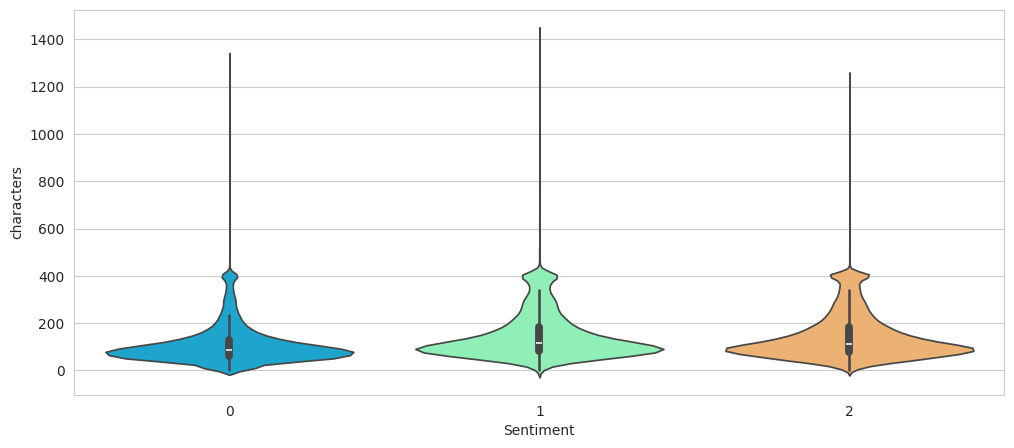

In [186]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df,x='Sentiment',y='characters',palette='rainbow')


##Analysis
It can be seen that the character lengths are distributed highly between 0 and 400 with a lot of ouliers.

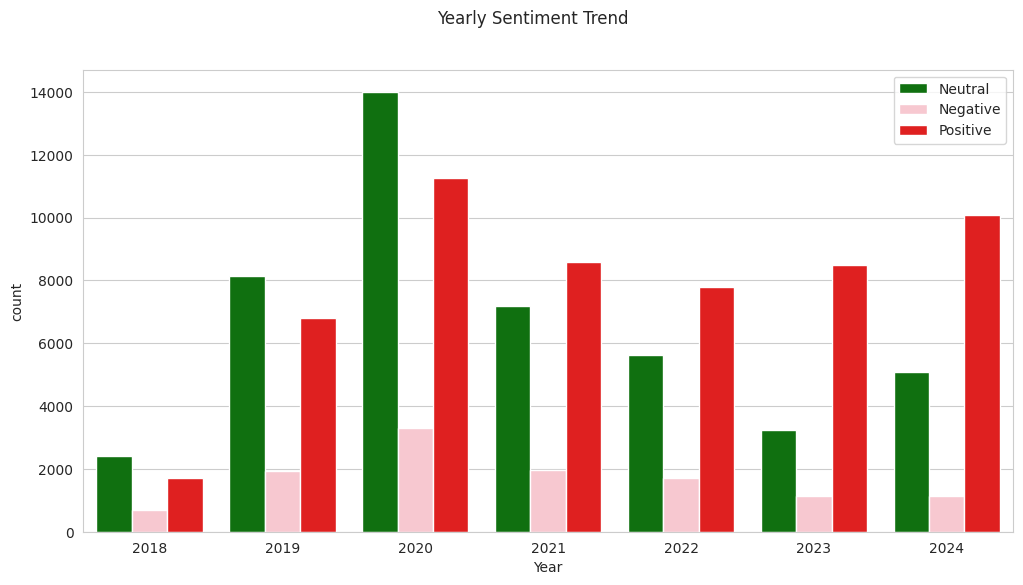

In [187]:

plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.countplot(data=df,x='Year',hue='Sentiment',palette={0:'green',1:'pink',2:'red'})
plt.suptitle('Yearly Sentiment Trend')
plt.legend(labels=['Neutral','Negative','Positive'])
plt.show()


## Chart Inference

From this graph it can be seen
 * from 2018 to 2020 the positive reviews greater than negative reviews an was on an increasing trend.
 * From 2021 to 2024 the negative reviews are more than positive reviews.
 * An event may have happened in 2020 for this trend (further studies can be made on what happened)


In [188]:
df.drop('Year',axis=1,inplace=True)

In [189]:
df.head()

,Reviews,Sentiment,characters
0,i rly wanted to watch my favourite show but it...,2,61
1,I love this app,0,12
2,Great love to enjoy watching latest movies and...,0,55
3,Please add all the MY little pony Seasons whic...,0,74
4,Nice app,0,7


## Text Preprocessing

### Removing Emojis ,Punctuations and other text cleaning steps

In [190]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002700-\U000027BF"  # dingbats
        "\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
        "\U00002600-\U000026FF"  # miscellaneous symbols
        "\U00002B50-\U00002B59"  # stars
        "\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
        "\U00002500-\U00002BEF"  # Chinese symbols
        "\U0001F004"             # Mahjong tile red dragon
        "\U0001F0CF"             # Playing card black joker
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [191]:
def clean_text(text):
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # convert to lower case
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove punctuations
    text = ''.join([character for character in text if character not in string.punctuation])

    # remove stop words
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # perform stemming
    ps=PorterStemmer()
    text = text.split()
    words = []
    for word in text:
        words.append(ps.stem(word))
    text = ' '.join(words)
    # remove emoji
    text = remove_emojis(text)
    # remove extra spaces
    text = ' '.join(text.split())
    return text

In [192]:
df=df.sample(10000)

In [193]:
df['Reviews']=df['Reviews'].apply(clean_text)


## SCALING AND SPLITTING THE DATA

In [194]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['characters']]=scaler.fit_transform(df[['characters']])

In [195]:
df.head()

,Reviews,Sentiment,characters
18612,bug netflix android app alter bright video pla...,2,0.273829
54332,problem open app sadli use,2,0.037964
35944,issu open account show pop would like watch tv...,2,0.117932
52571,think like wait load watch anim instead use cr...,2,0.079160
82741,amaz especi seri hd mode new one get new one r...,0,0.074313


In [196]:
X=df.drop('Sentiment',axis=1).values
y=df['Sentiment'].values

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## Vectorization

In [198]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
cv = CountVectorizer()
tfidf=TfidfTransformer()

In [199]:
X_train_text = X_train[ : , 0]
X_other_features = X_train[ : , 1: ]
X_train_bow = cv.fit_transform(X_train_text)
x__train_tfidf=tfidf.fit_transform(X_train_bow).toarray()
X_train_transformed = np.concatenate((x__train_tfidf, X_other_features), axis=1)

In [200]:
X_train = X_train_transformed
X_train.shape

(8000, 7910)

In [201]:
X_test_text = X_test[ : , 0]
X_other_features = X_test[ : , 1: ]
X_test_bow = cv.transform(X_test_text)
x__test_tfidf=tfidf.transform(X_test_bow).toarray()
X_test_transformed = np.concatenate((x__test_tfidf, X_other_features), axis=1)

In [202]:
X_test = X_test_transformed
X_test.shape

(2000, 7910)

##Evaluating Classification Models

In [203]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [204]:
mnc = MultinomialNB()
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
xgbc = XGBClassifier(n_estimators=50, random_state=42)

In [205]:
classfiers = {
    'MultinomialNB': mnc,
    'KNN':knn,
    'SVC':svc,
    'RandomForestClassifier':rfc,
    'XGBC':xgbc
}

In [206]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import cross_val_score

def train_model(clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred, average='weighted')
    kf_score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    return str(score*100)+'%' , str(p_score*100)+'%', str(kf_score.mean()*100)+'%'

In [207]:
precision = []
accuracy = []
k_fold = []
start_time = time.time()

for model,classifier in classfiers.items():
    acc,prec,kf = train_model(classifier)
    accuracy.append(acc)
    precision.append(prec)
    k_fold.append(kf)
    finish_time = time.time()
    print(f"{model} has been successfully evaluated. Total time taken is: {(finish_time-start_time)} seconds")
    start_time = finish_time

MultinomialNB has been successfully evaluated. Total time taken is: 20.72582244873047 seconds
KNN has been successfully evaluated. Total time taken is: 62.928046464920044 seconds
SVC has been successfully evaluated. Total time taken is: 2309.9629578590393 seconds
RandomForestClassifier has been successfully evaluated. Total time taken is: 100.26664972305298 seconds
XGBC has been successfully evaluated. Total time taken is: 176.89171242713928 seconds


In [208]:
score_comparison = pd.DataFrame({'Model': classfiers.keys(), 'Accuracy': accuracy, 'Precision': precision, 'K-Fold': k_fold})

##Comparing Metrics

In [209]:
score_comparison

,Model,Accuracy,Precision,K-Fold
0,MultinomialNB,77.14999999999999%,70.2547935237402%,75.275%
1,KNN,43.95%,59.13154246380559%,42.7625%
2,SVC,79.3%,72.12822506299868%,77.1875%
3,RandomForestClassifier,77.14999999999999%,69.94405686207179%,75.125%
4,XGBC,77.5%,71.62278109482385%,74.97500000000001%


##Creating a prediction Function

In [212]:
def predict_sentiment(review):
  characters=len(''.join(review.split()))
  characters=scaler.transform([[characters]])
  text_transform=(cv.transform([review])).toarray()
  input=np.hstack((text_transform,characters))
  prediction=mnc.predict(input)
  if prediction==0:
    return 'Positive'
  elif prediction==1:
    return 'Neutral'
  else:
    return 'Positive'

In [213]:
prediction = predict_sentiment("It is very easy to work with and even the kids love it!")
print(prediction)

Positive
